# Twitter Emotion Recognition Demo

Please check the README for full information and a recommended citation.

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

In [3]:
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [19]:
#  these are the examples from the demo.py file provided in the original repo - examples contain misogyny
tweets = [
    "Watching the sopranos again from start to finish!",
    "Finding out i have to go to the  dentist tomorrow",
    "Sun in my eyes but I don't mind, what a beautiful day we've had in New York today!",
    "Feels like someone's stabbed me in my hope",
    "Do people have no Respect for themselves or you know others peoples homes",
    "I want to go outside and chalk but I have no chalk",
    "I hate coming to the doctors when I feel as if I might have a big problem",
    "My mom wasn't mad",
    "You don't indicate once I'm already in the road THEN rev and honk at me you stupid bitch #learnhowtodrive #bitch",
    "Come home from work and this is on my doorstep. I guess he has a secret admirer",
    "The 'egyption hot models' facebook page is pathetic... simply photos of obese horny women.",
    "I HATE PAPERS AH #AH #HATE",
]

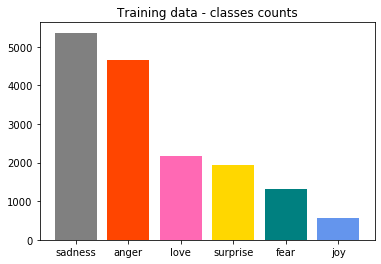

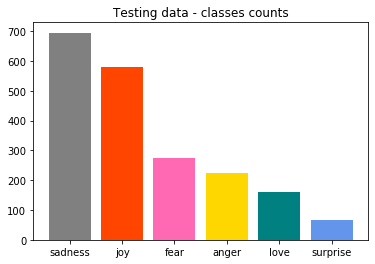

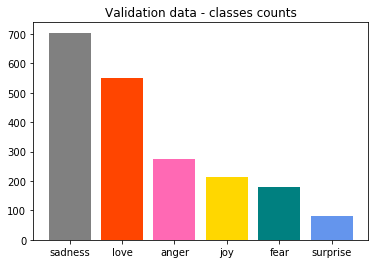

In [4]:
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [5]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [7]:
 #Read GloVE embeddings

path_to_glove_file = '/common/home/mr1609/data/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [8]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

2021-12-28 11:15:54.038034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-28 11:15:57.087947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12201 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b1:00.0, compute capability: 8.6
2021-12-28 11:15:57.091600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:b2:00.0, compute capability: 8.6
2021-12-28 11:15:57.093004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [9]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [10]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10


2021-12-28 11:16:22.068967: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 285s 4s/step - loss: 1.5838 - accuracy: 0.3548 - val_loss: 1.4342 - val_accuracy: 0.4535
Epoch 2/10
63/63 [==============================] - 273s 4s/step - loss: 1.1959 - accuracy: 0.5489 - val_loss: 0.8927 - val_accuracy: 0.6555
Epoch 3/10
63/63 [==============================] - 276s 4s/step - loss: 0.7401 - accuracy: 0.7419 - val_loss: 0.4881 - val_accuracy: 0.8300
Epoch 4/10
63/63 [==============================] - 285s 5s/step - loss: 0.3654 - accuracy: 0.8702 - val_loss: 0.2429 - val_accuracy: 0.9095
Epoch 5/10
63/63 [==============================] - 287s 5s/step - loss: 0.1982 - accuracy: 0.9207 - val_loss: 0.1935 - val_accuracy: 0.9185
Epoch 6/10
63/63 [==============================] - 291s 5s/step - loss: 0.1494 - accuracy: 0.9329 - val_loss: 0.1735 - val_accuracy: 0.9205
Epoch 7/10
63/63 [==============================] - 289s 5s/step - loss: 0.1286 - accuracy: 0.9393 - val_loss: 0.1679 - val_accuracy: 0.9255
Epoch 8/10
63/63 [======

In [12]:
model.save('lstm.h5')

In [2]:
# Recreate the exact same model, including its weights and the optimizer
import tensorflow as tf
new_model = tf.keras.models.load_model('lstm.h5')

# Show the model architecture
new_model.summary()

2021-12-28 12:08:50.604695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-28 12:08:52.922315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12201 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b1:00.0, compute capability: 8.6
2021-12-28 12:08:52.923832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:b2:00.0, compute capability: 8.6
2021-12-28 12:08:52.925211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        